# **User-based Collaborative Filtering Recommendations on MovieLens20M dataset**


## Objectives:

- Implement a user-based collaborative filtering algorithm.
- Utilize the `surprise` library for collaborative filtering.

----


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from IPython.display import display, Math, Latex

%matplotlib inline

In [2]:
# also set a random state
rs = 123

### Load and explore the dataset


First, let's load the datasets as `Pandas` dataframes and start some basic exploratory data analysis tasks on them.


In [3]:
movie_df = pd.read_csv('movie.csv')
ratings_df = pd.read_csv('rating.csv')

Let's first take a look at the datasets.

In [4]:
movie_df.head() 

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [6]:
print('movie_df.shape:', movie_df.shape,'; ratings_df.shape:', ratings_df.shape) 

movie_df.shape: (27278, 3) ; ratings_df.shape: (20000263, 4)


In [7]:
print('Number of rated movies:', ratings_df['movieId'].unique().size,'; number of unique users:', ratings_df['userId'].unique().size) 

Number of rated movies: 26744 ; number of unique users: 138493


Since here we don't use the time stamp for the moment, let us remove it from the user-rating matrix (URM)

In [8]:
urm_df = ratings_df.drop('timestamp',axis=1) 
urm_df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In the next steps, we create a sample from the original dataset sampling from 10000 users.

# Sample user-item matrix with 10000 users 

In [9]:
np.random.seed(rs)
sample_uesrs = np.random.choice(urm_df['userId'].unique(), size=10000, replace=False)

In [10]:
sample_users_df = urm_df[ratings_df['userId'].isin(sample_uesrs)]
sample_users_df

,userId,movieId,rating
960,11,1,4.5
961,11,10,2.5
962,11,19,3.5
963,11,32,5.0
964,11,39,4.5
...,...,...,...
19995144,138455,8169,3.5
19995145,138455,8622,4.0
19995146,138455,26324,4.0
19995147,138455,54881,4.0


In [11]:
print('Number of rated movies:', sample_users_df['movieId'].unique().size,'; number of unique users:', sample_users_df['userId'].unique().size) 

Number of rated movies: 16346 ; number of unique users: 10000


Let us obtain the average rating dataframe a given user gives to all items. We call this dataframe `user_avg_rating`.

In [12]:
user_avg_rating = sample_users_df.groupby('userId')[['rating']].mean().reset_index().rename(columns={"rating": "avg"})
user_avg_rating.shape

(10000, 2)

In [13]:
user_avg_rating

,userId,avg
0,11,3.945437
1,30,2.887097
2,36,2.800000
3,49,3.800000
4,55,4.166667
...,...,...
9995,138380,3.918182
9996,138385,4.068323
9997,138403,4.261905
9998,138419,4.190476


Now we can split the data into train and test sets. We set 10% to the test.

In [14]:
x_train, x_test, y_train, y_test = train_test_split(sample_users_df, sample_users_df['rating'], test_size=0.1, random_state = rs)

# User-user similarity matrix 

Now, in order to compute the user-user similarity matrix, we want to transform the URM into a sparse 2D matrix. We achieve it by using the `pivot()` method.

In [15]:
urm_sparse_df = x_train.pivot(index='userId', columns='movieId',values='rating').fillna(0).reset_index().rename_axis(index=None,columns=None)

In [16]:
print(urm_sparse_df.shape)
urm_sparse_df.head()

(10000, 15983)


,userId,1,2,3,4,5,6,7,8,9,...,130073,130328,130408,130420,130458,130490,130562,130626,130900,131158
0,11,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We collect the numerical data of `urm_sparse_df` to a numpy array `urm`.

In [17]:
urm = urm_sparse_df.loc[:,1:].to_numpy()
urm.shape 

(10000, 15982)

It would be useful now to create a dictionary to map `userId` to index in the `urm` matrix. 

In [18]:
user_list = urm_sparse_df.userId.to_list()

user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
user_idx2id_dict = {i: x for i, x in enumerate(user_list)}

Now we compute the user-user similarity matrix simply by using the numpy `corrcoef` method. It returns Pearson product-moment correlation coefficient matrix.

In [19]:
sim_user = np.corrcoef(urm)

In [20]:
# check the shape of the similarity matrix
sim_user.shape

(10000, 10000)

The similarity matrix is a symmetric matrix with dimension equal to the number of users (in the sample). Nex we plot the lower triangular part of the similarity matrix.

<Axes: >

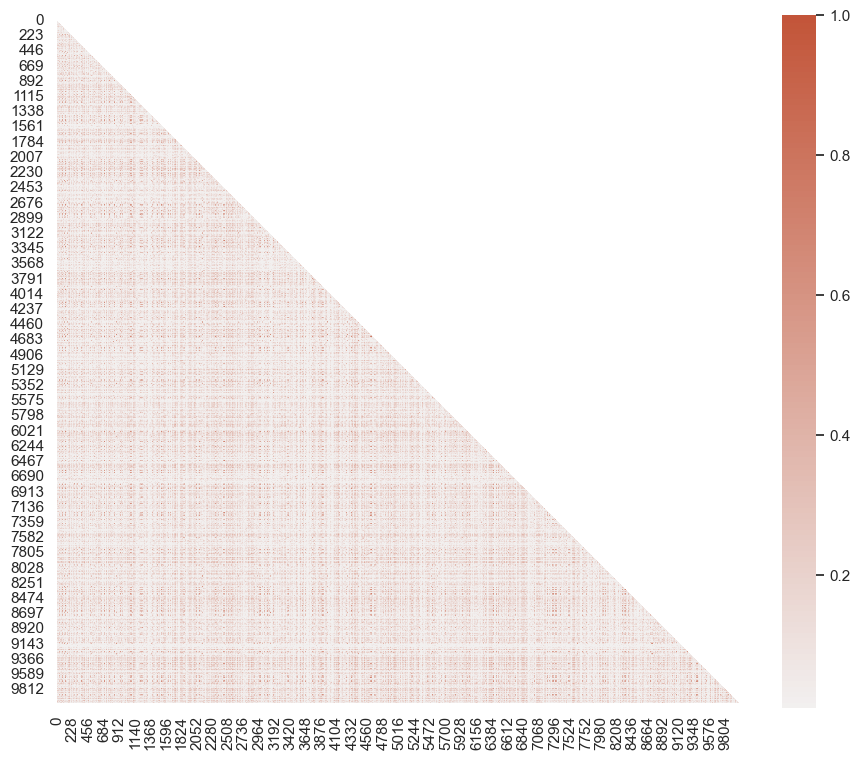

In [21]:
# Configure seaborn to set the plot style to 'white'
sns.set_theme(style="white")

# Create a mask for the upper triangle of the similarity matrix
mask = np.triu(np.ones_like(sim_user, dtype=bool))

# Create a new figure and axis for the heatmap
_, ax = plt.subplots(figsize=(11, 9))

# Create a diverging color palette for the heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Plot a similarity heat map using seaborn's heatmap function
sns.heatmap(sim_user, mask=mask, cmap=cmap, vmin=0.01, vmax=1, center=0,
            square=True)

The function `pred` takes the user u, item p, the URM matrix, and the dictionary to map index to userId, and returns the predicted rating. The equation is given below.

$$
r(u,p) = \overline{r_u} + \frac{\sum_{i \in \Omega_p} sim(u,i).(r_{ip}-\overline{r_i})}{\sum_{i \in \Omega_p} |sim(u,i)|}
$$

The second part of the equation is nothing but a deviation term for the user's average rating. We can call it S(u,p).

$$
S(u,p) =  \frac{\sum_{i \in \Omega_p} sim(u,i).(r_{ip}-\overline{r_i})}{\sum_{i \in \Omega_p} |sim(u,i)|}
$$

$$
r(u,p) = \overline{r_u} + S(u,p)
$$

In [22]:
def pred(u, p, k):
    """
    The function pred computes the predicted rating given by an user u to an item p inspired on the KNN method for a given k.
    input: u: user, p: item, urm: user-rating matrix, k: the maximum number of similar user (like KNN) to be compared with.
    output: predicted rating
    """
    # Notice, the similarity matrix "sim_user", the "user_avg_rating" and the "x_train" dataframes, and the 
    # dictionary "user_id2idx_dict" are implicit to the function. Be sure these pieces are defined before calling the function.

    # S_up is the deviation factor that it is to be added to the average rating given to user u to all items.
    s_up = 0 

    urm = x_train.copy()

    # The average rating given by user u to all items.
    r_u = user_avg_rating['avg'][user_id2idx_dict[u]] 

    user_df = urm[urm['movieId'] == p] # df of all users who rated the item p
    unique_users = user_df['userId'].unique() # the subset of users who have rated intem p
    ux = user_id2idx_dict[u] # index on sim_user corresponding to user u 

    # Here we create another dictionary to map userId to index in the just created user_df. 
    # Do not confuse id2idx_dict with user_id2idx_dict used with the user-user similarity matrix.
    user_listing = user_df.userId.to_list()
    id2idx_dict = {x: i for i, x in zip(user_df.index.to_list(),user_listing)}

    # the length of unique_users can be very large and we dont need to iterate through all of them.  Many users will not be similar anyway.
    # We can create a threshold and take only k users who are similar by more than the threshold to compute predictions.
    users_threshold = 0.3
    # similar_users is a list of tuples (user_i , similarity(u,i)) where similarity(u,i) > threshold
    similar_users = [(i, sim_user[ux][user_id2idx_dict[i]]) for i in unique_users if sim_user[ux][user_id2idx_dict[i]] > users_threshold]
    similar_users_sorted = sorted(similar_users, key=lambda tup: tup[1], reverse=True) # sort users by similarity in descending order
    # the next list takes the first k most similar users
    unique_users_max = [i[0] for i in similar_users_sorted][:k]

    # If there are no users similar up to the threshold, return the user average because the predicted rating would not be accurate anyway.
    if len(unique_users_max) == 0 : 
        return r_u
    
    else:
        #
        for i in unique_users_max: 
            ix = user_id2idx_dict[i] # index on sim_user corresponding to user i

            if ux != ix :
                simui = sim_user[ux][ix] # u,i matrix element of the user-user similarity matrix.
                rip = user_df['rating'][id2idx_dict[i]] # rating given by user i on item p
                ri_avg = user_avg_rating['avg'][ix] # average rating of user i to all items

                # mod is the denominator of the second part of equation above
                mod_user = [sim_user[ux][user_id2idx_dict[j]] for j in unique_users_max]
                mod = np.sum(mod_user)

                val = simui * (rip - ri_avg) / mod
                s_up += val

        return r_u + s_up

# Baseline RMSE: Use the average rating of the user as basemodel prediction:

Now that we programmed the function to make predictions, let us first set the baseline for testing. The first test is using the average rating of a user as the predicted rating.

We can achieve it by simply applying a lambda function on our test set with the user_avg_rating dataframe.

Remember that the similarity matrix has been computed utilizing the x_train dataset, which means that our model has not seen the users scores on the test dataset.

In [23]:
test_user_avg = x_test.userId.apply(lambda x: user_avg_rating['avg'][user_id2idx_dict[x]])


In [24]:
baseline = np.sqrt(mean_squared_error(test_user_avg, y_test))
print('RMSE of the basemodel:', baseline)

RMSE of the basemodel: 0.9570103162218884


With RMSE score of **0.9570**, our baseline is established. Next we compute the RMSE with the predicted ratings.

# Homemade user-user collaborative filtering 

Now we use our `pred` function to predic rating across the x_test dataset and compute the RMSE.

In [25]:
%%time
pred_test = x_test.apply(lambda x: pred(x.userId, x.movieId, 40), axis=1 )

CPU times: user 8min 5s, sys: 5min 4s, total: 13min 10s
Wall time: 10min 16s


In [26]:
cf = np.sqrt(mean_squared_error(pred_test, y_test))
print('RMSE of our user-user CF model:', cf)

RMSE of our user-user CF model: 0.8899989144580152


With RMSE of **0.8899**, we have demonstrated that the simple user-user collaborative filtering approach is able to provide good estimatives for the rating of the user to a given item, improving on the baseline approach.

# User-user collaborative filtering using Surprise library

Surprise is a Python sci-kit library for recommender systems. It is simple and comprehensive to build and test different recommendation algorithms.

Next we will try to recompute the RMSE on the same sampled dataset to compare with our implimentation.

In [27]:
from surprise import KNNBasic, NMF
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate

In [28]:
sample_users_df.to_csv('sample_df.csv', index=False, header=list(sample_users_df.columns))

In [29]:
# create the reader object with Read on the rating dataset with columns user item rating
reader = Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0.5, 5))

# Load the dataset from the CSV file
course_dataset = Dataset.load_from_file("sample_df.csv", reader=reader)

In [30]:
trainset, testset = train_test_split(course_dataset, test_size=.1)

In [31]:
# check how many users and items we can use to fit a KNN model:
print(f"Total {trainset.n_users} users and {trainset.n_items} items in the training set")

Total 10000 users and 15995 items in the training set


Perform KNN-based collaborative filtering on the user-item interaction matrix

In [32]:
sim_options = {'name': 'pearson', 'user_based': True}

# Build the KNNBasic algorithm, and train it.
model_KNN = KNNBasic(k=40, min_k=1, sim_options=sim_options, random_state = rs)


In [33]:
%%time
# Train the model
model_KNN.fit(trainset)
# Make predictions with KNN on the test set
predictions_knn = model_KNN.test(testset)
# Evaluate the model
kmm40 = accuracy.rmse(predictions_knn)
print('RMSE of model KNN:', kmm40)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9358
RMSE of model KNN: 0.9357795270616969
CPU times: user 1min 18s, sys: 4.19 s, total: 1min 22s
Wall time: 1min 24s


The RMSE here, **0.93577** was similar to the basemodel and higher than our implemented CF. 
Nonetheless, the computing time was significantly less compared to our simple implementation.